## Prerequisites

Mount Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir('/floyd/input/hgg')

In [ ]:
!pip install tables
!pip install nibabel
!pip install SimpleITK

Import dependencies

In [1]:
import numpy as np
import pandas as pd
import random
import os
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import keras
from keras import backend as K
import SimpleITK as sitk

####
import tables
import nibabel as nib
from tqdm import tqdm
from glob import glob


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3

In [2]:
image_size = 240      # 240 pixels by 240 pixels
smooth = 0.01         # used in loss, changed from .005

Specify the folder where images are located.

In [3]:
keras.backend.set_image_data_format('channels_first')

In [4]:
table_dir = '/home/poudelas/Documents/TF.Keras-Commonly-used-models-master/常用分割模型/Unet_family/table_data.hdf5'
hdf5_file = tables.open_file(table_dir, mode='r+')
data_storage    = hdf5_file.root.data
truth_storage   = hdf5_file.root.truth
brain_names     = hdf5_file.root.brain_names

print(data_storage.shape)
print(truth_storage.shape)

(259, 155, 2, 240, 240)
(259, 155, 240, 240)


In [5]:
#load validation and test brains and save them as numpy (still faster than nii.gz)
val_idx   = np.load('/home/poudelas/Documents/TF.Keras-Commonly-used-models-master/常用分割模型/Unet_family/val_idx.npy') # 27 brain indexes for validation
test_idx  = np.load('/home/poudelas/Documents/TF.Keras-Commonly-used-models-master/常用分割模型/Unet_family/test_idx.npy') # 27 brain indexes for testing

In [6]:
# We will use these numpys for validation and test generator
validation_save_dir = '/home/poudelas/PycharmProjects/efficientnet/val_save/'
for idx_val in val_idx:
    #print(data_storage[idx_val].shape)
    #print(truth_storage[idx_val].shape)                   
    name = brain_names[idx_val].decode("utf-8")
    print(name)
    folder = os.path.join(validation_save_dir, name)
    if not os.path.isdir(folder):
        os.mkdir(folder)
    np.save( os.path.join(validation_save_dir, folder, name + '_channels') , data_storage[idx_val])
    np.save( os.path.join(validation_save_dir, folder, name + '_label') , truth_storage[idx_val])
   

HGG_BraTS19_CBICA_BGN_1
HGG_BraTS19_TCIA01_390_1
HGG_BraTS19_CBICA_AVV_1
HGG_BraTS19_CBICA_BAP_1
HGG_BraTS19_TCIA03_265_1
HGG_BraTS19_TCIA03_121_1
HGG_BraTS19_TCIA03_296_1
HGG_BraTS19_TCIA04_437_1
HGG_BraTS19_CBICA_AQY_1
HGG_BraTS19_TCIA08_278_1
HGG_BraTS19_CBICA_AXQ_1
HGG_BraTS19_TCIA01_335_1
HGG_BraTS19_TCIA02_179_1
HGG_BraTS19_2013_26_1
HGG_BraTS19_2013_13_1
HGG_BraTS19_CBICA_BJY_1
HGG_BraTS19_TCIA04_328_1
HGG_BraTS19_TCIA03_498_1
HGG_BraTS19_TCIA01_460_1
HGG_BraTS19_TCIA06_211_1
HGG_BraTS19_TCIA04_149_1
HGG_BraTS19_TCIA08_162_1
HGG_BraTS19_CBICA_AWV_1
HGG_BraTS19_TCIA03_199_1
HGG_BraTS19_CBICA_AWG_1
HGG_BraTS19_CBICA_ANI_1


In [7]:
test_save_dir = '/home/poudelas/PycharmProjects/efficientnet/test_np/'
for idx_test in test_idx:
    #print(data_storage[idx_test].shape)
    #print(truth_storage[idx_test].shape)                   
    name = brain_names[idx_test].decode("utf-8")
    print(name)
    folder = os.path.join(test_save_dir, name)
    if not os.path.isdir(folder):
        os.mkdir(folder)
    np.save( os.path.join(test_save_dir, folder, name + '_channels') , data_storage[idx_test])
    np.save( os.path.join(test_save_dir, folder, name + '_label') , truth_storage[idx_test])

HGG_BraTS19_2013_10_1
HGG_BraTS19_TCIA05_444_1
HGG_BraTS19_2013_22_1
HGG_BraTS19_CBICA_AUN_1
HGG_BraTS19_TCIA08_242_1
HGG_BraTS19_CBICA_ASW_1
HGG_BraTS19_TCIA03_419_1
HGG_BraTS19_TCIA08_436_1
HGG_BraTS19_CBICA_AYG_1
HGG_BraTS19_2013_11_1
HGG_BraTS19_CBICA_ABN_1
HGG_BraTS19_CBICA_AOS_1
HGG_BraTS19_CBICA_ASG_1
HGG_BraTS19_TCIA06_372_1
HGG_BraTS19_TCIA01_180_1
HGG_BraTS19_CBICA_APY_1
HGG_BraTS19_CBICA_AOC_1
HGG_BraTS19_CBICA_AYA_1
HGG_BraTS19_CBICA_BLJ_1
HGG_BraTS19_CBICA_AQD_1
HGG_BraTS19_TCIA01_190_1
HGG_BraTS19_CBICA_APK_1
HGG_BraTS19_CBICA_AOH_1
HGG_BraTS19_CBICA_AQV_1
HGG_BraTS19_TMC_11964_1
HGG_BraTS19_CBICA_AUR_1


In [8]:
# closing the table
hdf5_file.close()

## Model Definition

Define Dice coefficient loss for segmentation. Let s use standard versions of this.

In [9]:
#source: https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/107182

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

Define uNet model for full tumour segmentation

In [25]:
def unet_model():
    inputs = keras.layers.Input((2, image_size, image_size)) #using 2 channels, one will be T2 and Flair later
    
    conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = keras.layers.BatchNormalization(axis=1)(conv1)
    conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = keras.layers.BatchNormalization(axis=1)(conv1)
    pool1 = keras.layers.MaxPooling2D((2, 2)) (batch1)
    
    conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = keras.layers.BatchNormalization(axis=1)(conv2)
    conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = keras.layers.BatchNormalization(axis=1)(conv2)
    pool2 = keras.layers.MaxPooling2D((2, 2)) (batch2)
    
    conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = keras.layers.BatchNormalization(axis=1)(conv3)
    conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = keras.layers.BatchNormalization(axis=1)(conv3)
    pool3 = keras.layers.MaxPooling2D((2, 2)) (batch3)
    
    conv4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = keras.layers.BatchNormalization(axis=1)(conv4)
    conv4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = keras.layers.BatchNormalization(axis=1)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = keras.layers.BatchNormalization(axis=1)(conv5)
    conv5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = keras.layers.BatchNormalization(axis=1)(conv5)
    
    up6 = keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = keras.layers.concatenate([up6, conv4], axis=1)
    conv6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = keras.layers.BatchNormalization(axis=1)(conv6)
    conv6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = keras.layers.BatchNormalization(axis=1)(conv6)
    
    up7 = keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = keras.layers.concatenate([up7, conv3], axis=1)
    conv7 =keras.layers. Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = keras.layers.BatchNormalization(axis=1)(conv7)
    conv7 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = keras.layers.BatchNormalization(axis=1)(conv7)
    
    up8 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = keras.layers.concatenate([up8, conv2], axis=1)
    conv8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = keras.layers.BatchNormalization(axis=1)(conv8)
    conv8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = keras.layers.BatchNormalization(axis=1)(conv8)
    
    up9 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = keras.layers.concatenate([up9, conv1], axis=1)
    conv9 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = keras.layers.BatchNormalization(axis=1)(conv9)
    conv9 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = keras.layers.BatchNormalization(axis=1)(conv9)

    conv10 = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(batch9) # sigmoid crunching number [0,1] for predicted probability of segment
                                                                          # close to 1 means tumor
    model = keras.models.Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=keras.optimizers.Adam(lr=1e-6), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [12]:
# import efficientnet.keras as efn
# from keras.models import Model
# from keras.layers.convolutional import Conv2D
# from keras.layers import LeakyReLU, Add, Input,MaxPool2D,UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout
# base_model = efn.EfficientNetB0(weights=None,include_top=False,input_shape=(224,224,2))


# input_model = base_model.input
# start_neurons = 8
# dropout_ratio = 0.1

# def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
#     x = Conv2D(filters, size, strides=strides, padding=padding)(x)
#     x = BatchNormalization()(x)
#     if activation == True:
#         x = LeakyReLU(alpha=0.1)(x)
#     return x

# def residual_block(blockInput, num_filters=16):
#     x = LeakyReLU(alpha=0.1)(blockInput)
#     x = BatchNormalization()(x)
#     blockInput = BatchNormalization()(blockInput)
#     x = convolution_block(x, num_filters, (3,3) )
#     x = convolution_block(x, num_filters, (3,3), activation=False)
#     x = Add()([x, blockInput])
#     return x


# conv5 = base_model.get_layer('top_activation').output
# conv4 = base_model.get_layer('block6a_expand_activation').output
# conv3 = base_model.get_layer('block4a_expand_activation').output
# conv2 = base_model.get_layer('block3a_expand_activation').output
# conv1 = base_model.get_layer('block2a_expand_activation').output

# #Middle 7*7
# convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(conv5)
# convm = residual_block(convm,start_neurons * 32)
# convm = residual_block(convm,start_neurons * 32)
# convm = LeakyReLU(alpha=0.1)(convm) #7*7

# #14*14
# deconv4 = Conv2DTranspose(start_neurons*16,(3,3),strides=(2,2),padding="same")(convm)
# uconv4 = concatenate([deconv4,conv4])
# uconv4 = Dropout(dropout_ratio)(uconv4)
# uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
# uconv4 = residual_block(uconv4,start_neurons * 16)
# uconv4 = LeakyReLU(alpha=0.1)(uconv4)

# #28*28
# deconv3 = Conv2DTranspose(start_neurons*8,(3,3),strides=(2,2),padding="same")(uconv4)
# uconv3 = concatenate([deconv3,conv3])
# uconv3 = Dropout(dropout_ratio)(uconv3)
# uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
# uconv3 = residual_block(uconv3,start_neurons * 8)
# uconv3 = LeakyReLU(alpha=0.1)(uconv3)

# #56*56
# deconv2 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2,2),padding="same")(uconv3)
# uconv2 = concatenate([deconv2,conv2])
# uconv2 = Dropout(dropout_ratio)(uconv2)
# uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
# uconv2 = residual_block(uconv2,start_neurons * 4)
# uconv2 = LeakyReLU(alpha=0.1)(uconv2)

# #112*112
# deconv1 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2,2),padding="same")(uconv2)
# uconv1 = concatenate([deconv1,conv1])
# uconv1 = Dropout(dropout_ratio)(uconv1)
# uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
# uconv1 = residual_block(uconv1,start_neurons * 2)
# uconv1 = LeakyReLU(alpha=0.1)(uconv1)

# #224*224
# deconv0 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2,2),padding="same")(uconv1)
# uconv0 = Dropout(dropout_ratio)(deconv0)
# uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
# uconv0 = residual_block(uconv0,start_neurons * 1)
# uconv0 = LeakyReLU(alpha=0.1)(uconv0)

# output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)

# model = Model(input_model,[output_layer])
# print(model.summary())


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:272: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 224 input channels.
  str(input_shape[0]) + ' input channels.')


ValueError: Input size must be at least 32x32; got `input_shape=(224, 224, 2)`

In [26]:
model_full = unet_model()

## Data Generator


In [27]:
"""
Utilities for real-time multi-thread data generator
"""

import scipy
import numpy as np
from keras.utils import Sequence, to_categorical

from keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(Sequence):
    
    def __init__(self, hdf5_file, brain_idx, batch_size=16, mode='train', horizontal_flip=False,
                 vertical_flip=False, rotation_range=0, zoom_range=0., shuffle=True):
        """
        Custom data generator based on Keras Sequance class.
        This implementation enables multiprocessing and on-the-fly data augmentation 
        which will speed up training, especially in the task of brain tumor segmentation
        that suffers from time-consuming data processing.
        
        Parameters
        ----------
        hdf5_file : file.File
            An opend hdf5 file that contains all data.
        brain_idx : array
            The brain indexes corresponing to a specific fold. All of these 
            brain indexes will be use for training and the ones which are 
            not in 'brain_idx' will be used for validation
        batch_size : int
            The number of input/output arrays that will be generated each 
            time. The default is 16.
        view : str
            'axial', 'sagittal' or 'coronal'. The generator will extract
            2D slices and perform normalization with respect to the chosen view.
            The defualt is axial.
        mode : str
            Prepare the DataGenerator for 'train' or 'validation' phase. 
            The default is 'train'.
        horizontal_flip : bool
            Whether to use horizontal flip for data augmentation. The default is False.
        vertical_flip : bool
            Whether to use vertical flip for data augmentation. The default is False.
        rotation_range : float
            Random rotation for data augmentation. The default is 0.
        zoom_range : float
            Random zoom for data augmentation. The default is 0.
        shuffle : bool
            Whether to shuffle data. The default is True. Note that if mode='validation' 
            it will not shufflw tha data.

        """
        
        self.data_storage    = hdf5_file.root.data
        self.truth_storage   = hdf5_file.root.truth   
        
        total_brains         = self.data_storage.shape[0]
        self.brain_idx       = brain_idx
        self.batch_size      = batch_size
        
        '''
        if view == 'axial':
            self.view_axes = (0, 1, 2, 3)            
        elif view == 'sagittal': 
            self.view_axes = (2, 1, 0, 3)
        elif view == 'coronal':
            self.view_axes = (1, 2, 0, 3)            
        else:
            ValueError('unknown input view => {}'.format(view))
        '''  
        
        self.mode            = mode
        self.horizontal_flip = horizontal_flip
        self.vertical_flip   = vertical_flip
        self.rotation_range  = rotation_range       
        self.zoom_range      = [1 - zoom_range, 1 + zoom_range]
        self.shuffle         = shuffle
        self.data_shape      = tuple(np.array(self.data_storage.shape[1:]))
        
        print('model: {}'.format(mode))
        print('Using {} out of {} brains'.format(len(self.brain_idx), total_brains), end=' ')
        print('({} out of {} 2D slices)'.format(len(self.brain_idx) * self.data_shape[0], total_brains * self.data_shape[0]))
        print('-----'*10)
        

        self.on_epoch_end()   
        
    def __len__(self):
        return int(np.floor( len(self.indexes) / self.batch_size))
    
    
    def __getitem__(self, index):

        # Generate indexes of the batch
        idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X_batch, Y_batch = self.data_load_and_preprocess(idx)

        return X_batch, Y_batch

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        tmp=[]
        for i in self.brain_idx:
            for j in range(self.data_shape[0]):
                tmp.append((i,j))
        self.indexes = tmp
            
        if self.mode=='train' and self.shuffle:
            np.random.shuffle(self.indexes)
            
            
    def data_load_and_preprocess(self, idx):
        """
        Generates data containing batch_size samples
        """
        slice_batch = []
        label_batch = []

        # Generate data
        for i in idx:
            brain_number     = i[0]
            slice_number     = i[1]
            slice_, label_   = self.read_data(brain_number, slice_number)
            #slice_           = self.normalize_modalities(slice_)
            slice_and_label  = np.concatenate((slice_, label_) , axis=0)
            params           = self.get_random_transform()
            slice_and_label  = self.apply_transform(slice_and_label, params)
            slice_           = slice_and_label[:2]
            label_           = slice_and_label[2:]
            #label_           = to_categorical(label_, 4) 
            
            slice_batch.append(slice_)
            label_batch.append(label_)
            
        return np.array(slice_batch), np.array(label_batch)
    
    
    
    def read_data(self, brain_number, slice_number):
        
        """
        Reads data from table with respect to the 'view'
        
        """
        
        slice_    = self.data_storage[brain_number][slice_number]
        label_    = self.truth_storage[brain_number][slice_number]
        label_    = np.expand_dims(label_, axis=0)
        
        return slice_, label_ 
        
    
    def normalize_slice(self, slice):
        
        """
        Removes 1% of the top and bottom intensities and perform
        normalization on the input 2D slice.
        """
        b = np.percentile(slice, 99)
        t = np.percentile(slice, 1)
        slice = np.clip(slice, t, b)
        if np.std(slice)==0:
            return slice
        else:
            slice = (slice - np.mean(slice)) / np.std(slice)
            return slice
        
        
    def normalize_modalities(self, Slice): 
        
        """
        Performs normalization on each modalities of input
        """

        normalized_slices = np.zeros_like(Slice).astype(np.float32)
        for slice_ix in range(4):
            normalized_slices[..., slice_ix] = self.normalize_slice(Slice[..., slice_ix])
    
        return normalized_slices  
    

    def flip_axis(self, x, axis):
        
        x = np.asarray(x).swapaxes(axis, 0)
        x = x[::-1, ...]
        x = x.swapaxes(0, axis)
        return x
    
    
    def apply_transform(self, x, transform_parameters):
        
        x = apply_affine_transform(x, transform_parameters.get('theta', 0),
                           transform_parameters.get('tx', 0),
                           transform_parameters.get('ty', 0),
                           transform_parameters.get('shear', 0),
                           transform_parameters.get('zx', 1),
                           transform_parameters.get('zy', 1),
                           row_axis=0,
                           col_axis=1,
                           channel_axis=0)
        if transform_parameters.get('flip_horizontal', False):
            x = self.flip_axis(x, 2)
        if transform_parameters.get('flip_vertical', False):
            x = self.flip_axis(x, 1)            
        return x
        
    def get_random_transform(self):
    
        if self.rotation_range:
            theta = np.random.uniform(-self.rotation_range,self.rotation_range)    
        else:
            theta = 0            
 
        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0],self.zoom_range[1], 2)
            
        flip_horizontal = (np.random.random() < 0.5) * self.horizontal_flip    
        flip_vertical   = (np.random.random() < 0.5) * self.vertical_flip
        
        transform_parameters = {'flip_horizontal': flip_horizontal,
                                'flip_vertical':flip_vertical,
                                'theta': theta, 
                                'zx': zx, 
                                'zy': zy}
    
        return transform_parameters        
        
"""
The two following functions are from ImageDataGenerator class of keras.
https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py
"""
    
def apply_affine_transform(x, theta=0, tx=0, ty=0, shear=0, zx=1, zy=1,
                           row_axis=0, col_axis=1, channel_axis=2,
                           fill_mode='nearest', cval=0.):
    """Applies an affine transformation specified by the parameters given.

    # Arguments
        x: 2D numpy array, single image.
        theta: Rotation angle in degrees.
        tx: Width shift.
        ty: Heigh shift.
        shear: Shear angle in degrees.
        zx: Zoom in x direction.
        zy: Zoom in y direction
        row_axis: Index of axis for rows in the input image.
        col_axis: Index of axis for columns in the input image.
        channel_axis: Index of axis for channels in the input image.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        The transformed version of the input.
    """
    transform_matrix = None
    if theta != 0:
        theta = np.deg2rad(theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        transform_matrix = rotation_matrix

    if tx != 0 or ty != 0:
        shift_matrix = np.array([[1, 0, tx],
                                 [0, 1, ty],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shift_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shift_matrix)

    if shear != 0:
        shear = np.deg2rad(shear)
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shear_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shear_matrix)

    if zx != 1 or zy != 1:
        zoom_matrix = np.array([[zx, 0, 0],
                                [0, zy, 0],
                                [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = zoom_matrix
        else:
            transform_matrix = np.dot(transform_matrix, zoom_matrix)

    if transform_matrix is not None:
        h, w = x.shape[row_axis], x.shape[col_axis]
        transform_matrix = transform_matrix_offset_center(
            transform_matrix, h, w)
        x = np.rollaxis(x, channel_axis, 0)
        final_affine_matrix = transform_matrix[:2, :2]
        final_offset = transform_matrix[:2, 2]

        channel_images = [scipy.ndimage.interpolation.affine_transform(
            x_channel,
            final_affine_matrix,
            final_offset,
            order=1,
            mode=fill_mode,
            cval=cval) for x_channel in x]
        x = np.stack(channel_images, axis=0)
        x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

In [28]:
from glob import glob

def imgDataGen_full(data_dir, batch_size = 20):
    i = 0
    slc = 0  
    all_brain_dirs = glob(data_dir+'/*') # * means everything in that directory
    i_max = len(all_brain_dirs)-1
    #takes care of iterating the entire batch
    brain_channels = np.load(glob(os.path.join(all_brain_dirs[i],'*_channels*'))[0])
    Seg_full       = np.load(glob(os.path.join(all_brain_dirs[i],'*_label*'))[0])
    while True:    
        if slc+batch_size>154:
            i += 1
            slc=0
            if i>i_max:
                i=0
            brain_channels = np.load(glob(os.path.join(all_brain_dirs[i],'*_channels*'))[0])
            Seg_full       = np.load(glob(os.path.join(all_brain_dirs[i],'*_label*'))[0])
        
        #Pulling in the data and calling read_data function to numpy arrays                               
        #the convolutional layer expects data in this format
        #(batch_size, channels, img_height, img_width)
        img_train = np.zeros((batch_size,2,240,240),np.float32) #creates an array in required dimensions
        img_seg   = np.zeros((batch_size,1,240,240),np.float32) #img segment is ground truth/mask/label, creates an array in required dimensions

        for m in range(batch_size):                           #the training image includes pixels from Img_Flair and Img_T2
            img_train[m,:,:,:] = brain_channels[slc+m:slc+m+1,:,:,:] #the first channel of the image has data from Img_Flair, 0 corresponds to first channel
            img_seg [m,0,:,:]  = Seg_full[slc+m:slc+m+1,:,:]  #now preparing training label, Seg_full contains whole tumor mask details, single channel 0
        slc += batch_size                                     #takes care of iterating entire batch
        yield [img_train, img_seg]                            #returns image and ground truth for this batch

In [29]:
# testing generator 

val_dir = '/home/poudelas/PycharmProjects/efficientnet/val_save/'
val_gen = imgDataGen_full(val_dir, batch_size = 20)
x_batch, y_batch = next(val_gen)
print(x_batch.shape)
print(y_batch.shape)


(20, 2, 240, 240)
(20, 1, 240, 240)


## Train and Evaluate the model on images

Train the model.

In [30]:
hdf5_file.close()

In [31]:
table_dir1 = '/home/poudelas/Documents/TF.Keras-Commonly-used-models-master/常用分割模型/Unet_family/table_data.hdf5'
hdf5_file1 = tables.open_file(table_dir1, mode='r+')

#table_dir2 = './table_data2.hdf5'
#hdf5_file2 = tables.open_file(table_dir2, mode='r+')

In [ ]:
n_epochs = 10

train_idx = np.load('/home/poudelas/Documents/TF.Keras-Commonly-used-models-master/常用分割模型/Unet_family/train_idx.npy') # 207 brain indexes for training
#val_idx   = np.load('val_idx.npy') # 27 brain indexes for validation
#test_idx  = np.load('test_idx.npy') # 27 brain indexes for testing
val_dir = '/home/poudelas/PycharmProjects/efficientnet/val_save/'
test_dir = '/home/poudelas/PycharmProjects/efficientnet/test_np/'

train_gen = CustomDataGenerator(hdf5_file1, train_idx, batch_size=20, mode='train', 
                                horizontal_flip=True, vertical_flip=True, shuffle=True)

val_gen =  imgDataGen_full(val_dir, batch_size = 20)
test_gen =  imgDataGen_full(test_dir, batch_size = 20)
# there is no need to set steps_per_epoch, When we use a sequence generator, len(generator) will be considered as steps.
#history = model_full.fit_generator(train_gen, epochs=n_epochs, use_multiprocessing=False)

# validation_steps = #brains * #slices / batch_size
history = model_full.fit_generator(train_gen, epochs=n_epochs, use_multiprocessing=False, validation_data = val_gen, validation_steps=int((27 * 155)/10))


model: train
Using 207 out of 259 brains (32085 out of 40145 2D slices)
--------------------------------------------------
Epoch 1/10
1604/1604 [==============================] - 1516s 945ms/step - loss: 0.9259 - dice_coef: 0.0741 - val_loss: 0.9332 - val_dice_coef: 0.0668
Epoch 2/10
1004/1604 [=================>............] - ETA: 8:32 - loss: 0.9032 - dice_coef: 0.0968

In [18]:
model_full.save('mark1.h5')

Plot training & validation accuracy

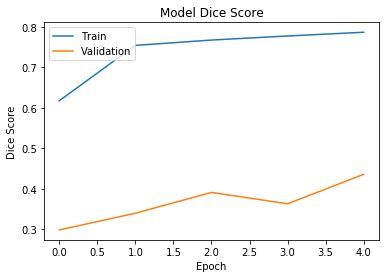

In [19]:
# Plot training & validation learning curves
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model Dice Score')
plt.ylabel('Dice Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Mean Dice During Training

In [20]:
np.mean(history.history['dice_coef'])

0.7406793

Standard Deviation During Training

In [21]:
np.std(history.history['dice_coef'])

0.062456872

Evaluate model on test data

In [39]:
score = model_full.evaluate_generator(test_gen, steps=1, use_multiprocessing=False)

In [40]:
print('Testing dice loss:', score[0])
print('Testing dice score:', score[1])

Testing dice loss: 0.022849619388580322
Testing dice score: 0.9771503806114197


Confusion Matrix For Testing

## Predict segmentation on few sample images

In [ ]:
#using Flair and T2 as input for full tumor segmentation
x = np.zeros((1,2,240,240),np.float32)
x[:,:1,:,:] = Img_Flair[80:81,:,:,:]
x[:,1:,:,:] = Img_T2[80:81,:,:,:] 

pred_full = model_full.predict(x)

In [ ]:
slice_no = 80
plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('T2')
plt.axis('off')
plt.imshow(Img_T2[slice_no, 0, :, :],cmap='gray')
    
plt.subplot(142)
plt.title('Flair')
plt.axis('off')
plt.imshow(Img_Flair[slice_no, 0, :, :],cmap='gray')

plt.subplot(143)
plt.title('Ground Truth(full)')
plt.axis('off')
plt.imshow(Seg_full[slice_no, 0, :, :],cmap='gray')

plt.subplot(144)
plt.title('prediction(full)')
plt.axis('off')
plt.imshow(pred_full[0, 0, :, :],cmap='gray')

plt.show()